# Plot strain-specific model fits and song statistics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from aux import get_seg
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS


COMBOS = [('NM91', 'ZH23'), ('CM07', 'CSTul'), ('N30', 'ZW109')]

KEYS = ['_'.join(COMBO).lower() for COMBO in COMBOS]
REG_KEY = 'ridge_alpha_10'

FSTRAIN = 'data/simple/strains.csv'
MCOMBOS = []
for COMBO in COMBOS:
    temp = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in COMBO]
    MCOMBOS.append(np.any(temp, axis=0))
ICOMBOS = [MCOMBO.nonzero()[0] for MCOMBO in MCOMBOS]

## Motion predictions

In [2]:
TARG_BHV = 'MTN'
TWDWS = [.03, 1, 60]
TARGS = [f'{TARG_BHV}_MN_{twdw}' for twdw in TWDWS]

LABELS = {
    'linma': 'Linear',
    'lnma': 'LN',
    'ma': 'MA',
    'MTN': 'Motion',
}

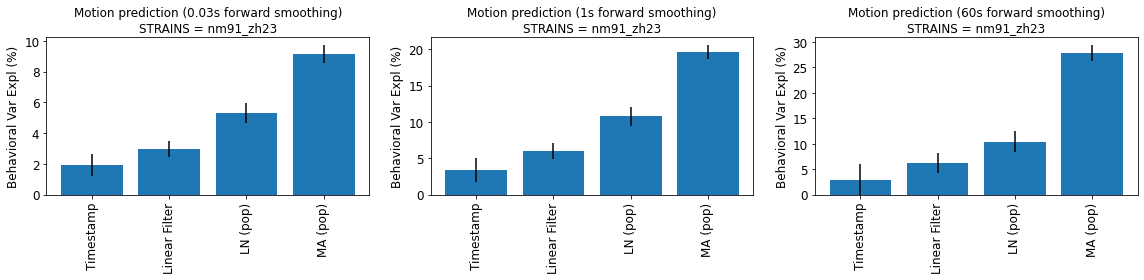

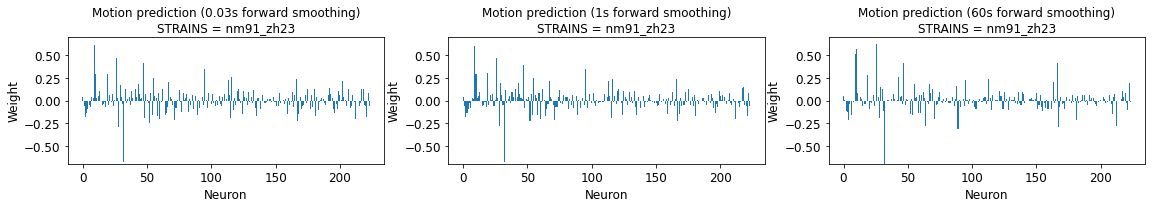

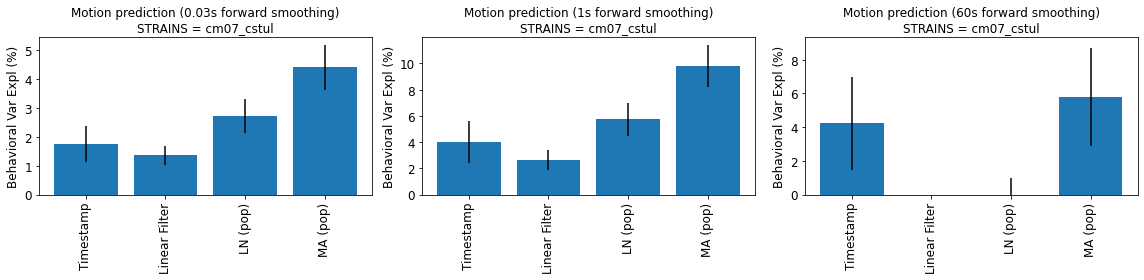

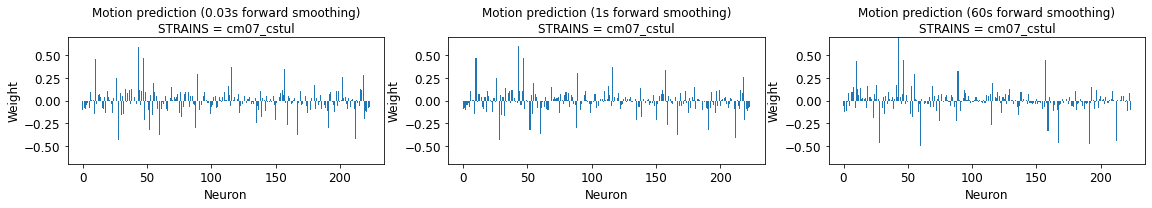

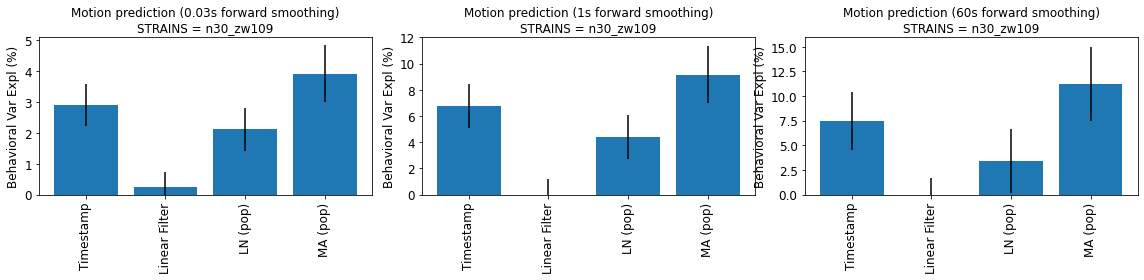

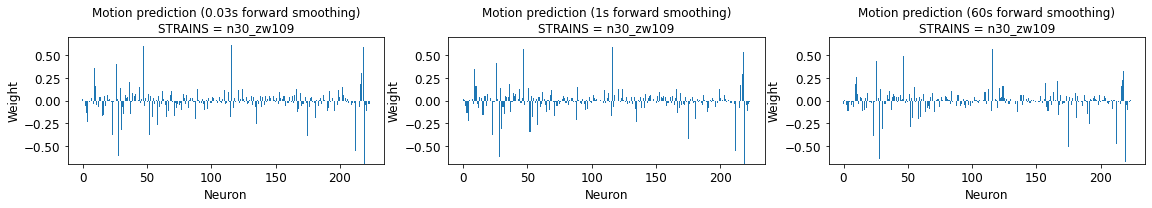

In [3]:
NRL_MDLS = ['lnma', 'ma']

for key in KEYS:
    
    # heuristic predictors
    time_rslt = np.load(f'data/simple/mlv/heuristic/time_{key}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]

    # linear fits
    lin_rslt = np.load(f'data/simple/mlv/lin_filter/rc_lin_{key}_{TARG_BHV.lower()}_{REG_KEY}.npy', allow_pickle=True)[0]
    
    # ppln fits
    ppln_rslts = [
        np.load(f'data/simple/mlv/neur_basic/by_strain/baker_{nrl_mdl}_{key}_{TARG_BHV.lower()}.npy', allow_pickle=True)[0]
        for nrl_mdl in NRL_MDLS
    ]

    fig, axs = plt.subplots(1, 3, figsize=(16, 4), tight_layout=True)

    for ax, twdw in zip(axs, TWDWS):
        labels = []
        r2_mns = []
        r2_sems = []

        targ = f'{TARG_BHV}_MN_{twdw}'

        # heuristics
        labels.append('Timestamp')
        r2_mns.append(time_rslt['r2_test'][targ].mean())
        r2_sems.append(time_rslt['r2_test'][targ].std() / np.sqrt(time_rslt['nsplit']))

        # linear fits
        labels.append('Linear Filter')
        r2_mns.append(lin_rslt['r2_test'][targ].mean())
        r2_sems.append(lin_rslt['r2_test'][targ].std() / np.sqrt(lin_rslt['nsplit']))

        # # single neuron results
        # for nrl_mdl, single_rslt in zip(NRL_MDLS, single_rslts):
        #     r2_maxs = single_rslt['r2_test'][targ].max(axis=1)
        #     labels.append(f'{LABELS[nrl_mdl]} (best)')
        #     r2_mns.append(r2_maxs.mean())
        #     r2_sems.append(r2_maxs.std() / np.sqrt(len(r2_maxs)))

        # ppln results
        for nrl_mdl, ppln_rslt in zip(NRL_MDLS, ppln_rslts):
            labels.append(f'{LABELS[nrl_mdl]} (pop)')
            r2_mns.append(ppln_rslt['r2_test'][targ].mean())
            r2_sems.append(ppln_rslt['r2_test'][targ].std() / np.sqrt(ppln_rslt['nsplit']))

        # # shuffled MA fit
        # labels.append('MA (shuffled)')
        # r2_mns.append(shfl_rslt['r2_test'][targ].mean())
        # r2_sems.append(shfl_rslt['r2_test'][targ].std() / np.sqrt(shfl_rslt['nshfl']))

        r2_mns = np.array(r2_mns)
        r2_sems = np.array(r2_sems)

        ax.bar(np.arange(len(r2_mns)), 100*r2_mns, yerr=100*r2_sems)
        ax.set_ylim(bottom=0)
        ax.set_xticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=90)
        set_plot(ax, y_label='Behavioral Var Expl (%)', title=f'{LABELS[TARG_BHV]} prediction ({twdw}s forward smoothing)\nSTRAINS = {key}', font_size=12)
        
    fig, axs = plt.subplots(1, 3, figsize=(16, 3), tight_layout=True)

    for ax, twdw in zip(axs, TWDWS):
        targ = f'{TARG_BHV}_MN_{twdw}'
        
        ppln_rslt = ppln_rslts[1]  # MA
        ax.bar(np.arange(224), ppln_rslt['w'][targ].mean(0))
        set_plot(ax, y_lim=(-.7, .7), x_label='Neuron', y_label='Weight', title=f'{LABELS[TARG_BHV]} prediction ({twdw}s forward smoothing)\nSTRAINS = {key}', font_size=12)

In [4]:
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')
# split big df into dfs for individual trials
n_tr = np.max(df_behav.ID) + 1

df_behav

,ID,FRAME,T,Q,S,P,F,FFV,FFA,FLS,FRS,FMFV,FMLS
0,0,0,0.000000,1,0,0,0,0.231,0.0000,0.159,0.077,-0.058526,0.274257
1,0,1,0.033300,1,0,0,0,0.314,0.0385,0.025,0.044,0.100623,0.298490
2,0,2,0.066600,1,0,0,0,0.308,0.0025,0.029,0.011,0.147629,0.271865
3,0,3,0.099900,1,0,0,0,0.319,0.0020,0.016,0.016,0.091174,0.306112
4,0,4,0.133200,1,0,0,0,0.312,-0.0315,0.030,0.002,0.065871,0.306439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4978565,275,27100,902.430902,1,0,0,0,0.217,0.0280,0.029,0.058,-0.171418,0.136184
4978566,275,27101,902.464202,1,0,0,0,0.210,-0.1045,0.138,0.322,0.032522,0.249171
4978567,275,27102,902.497502,1,0,0,0,0.008,-0.0910,0.034,0.260,0.033202,0.010844
4978568,275,27103,902.530803,1,0,0,0,0.028,0.0695,0.010,0.090,0.012059,0.027177


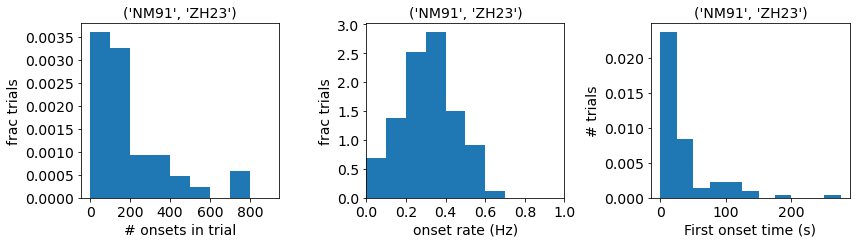

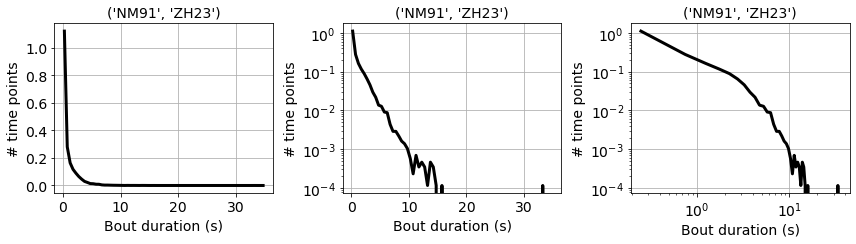

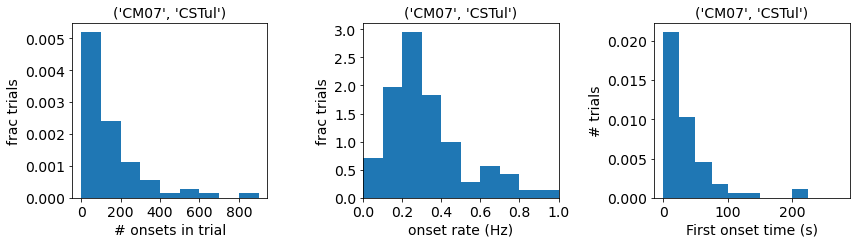

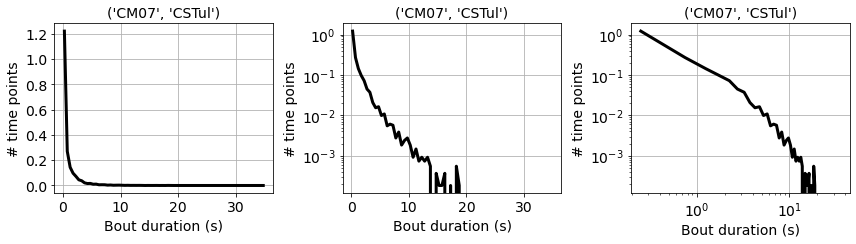

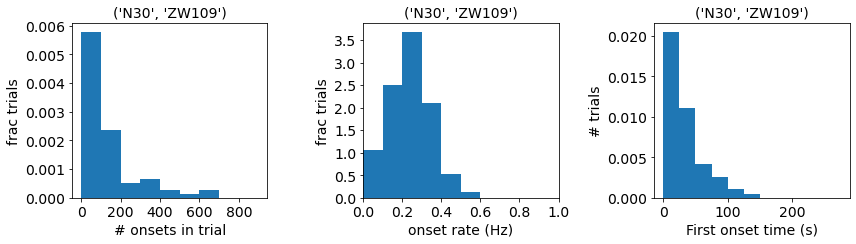

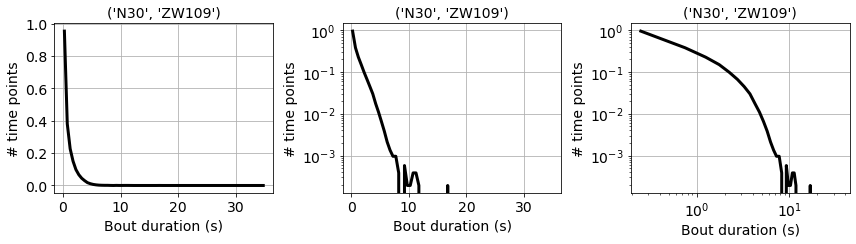

In [5]:
for ICOMBO, COMBO in zip(ICOMBOS, COMBOS):
    dfs_tr = [df_behav[df_behav.ID == i] for i in ICOMBO]
    tr_lens = [len(df_tr) for df_tr in dfs_tr]

    # distribution of song onsets
    nonsets = []
    rate_onsets = []
    t_first_onsets = []

    bout_durs_all = []

    for df_tr in dfs_tr:
        singing = ~np.array(df_tr['Q']).astype(bool)
        seg, bds = get_seg(singing, min_gap=1)
        nonset = len(seg)

        nonsets.append(nonset)
        rate_onsets.append(nonset/(DT*len(df_tr)))
        t_first_onsets.append(bds[0][0]*DT)

        bout_durs_all.append(DT*(bds[:, 1] - bds[:, 0]))

    bout_durs_all = cc(bout_durs_all)

    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
    axs[0].hist(nonsets, bins=np.linspace(0, 900, 10), density=True)
    axs[0].set_xlabel('# onsets in trial')
    axs[0].set_ylabel('frac trials')

    axs[1].hist(rate_onsets, bins=np.linspace(0, 1, 11), density=True)
    axs[1].set_xlim(0, 1)
    axs[1].set_xlabel('onset rate (Hz)')
    axs[1].set_ylabel('frac trials')

    axs[2].hist(t_first_onsets, bins=np.linspace(0, 275, 12), density=True)
    axs[2].set_xlabel('First onset time (s)')
    axs[2].set_ylabel('# trials')

    for ax in axs:
        set_plot(ax, title=f'{COMBO}', font_size=14)


    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), tight_layout=True)
    cts, bins = np.histogram(bout_durs_all, bins=np.linspace(0, 35, 71), density=True)
    binc = .5*(bins[:-1] + bins[1:])

    axs[0].plot(binc, cts, lw=3, c='k')

    axs[1].plot(binc, cts, lw=3, c='k')
    axs[1].set_yscale('log')

    axs[2].plot(binc, cts, lw=3, c='k')
    axs[2].set_xscale('log')
    axs[2].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('Bout duration (s)')
        ax.set_ylabel('# time points')
        ax.grid()
        set_plot(ax, title=f'{COMBO}', font_size=14)

# Frac trials singing and singing in each mode over time

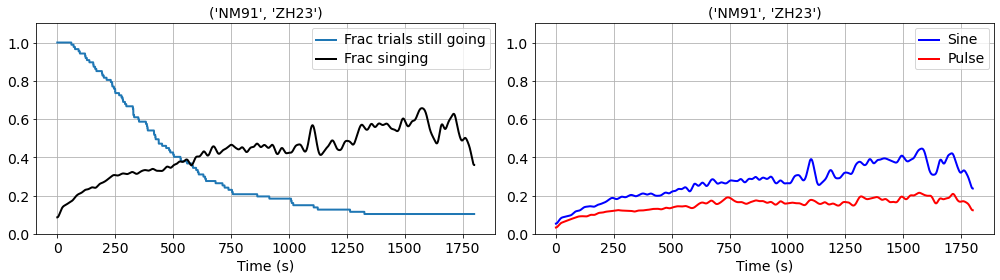

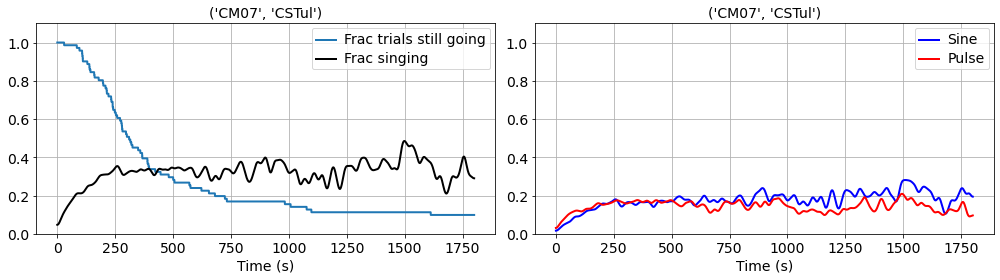

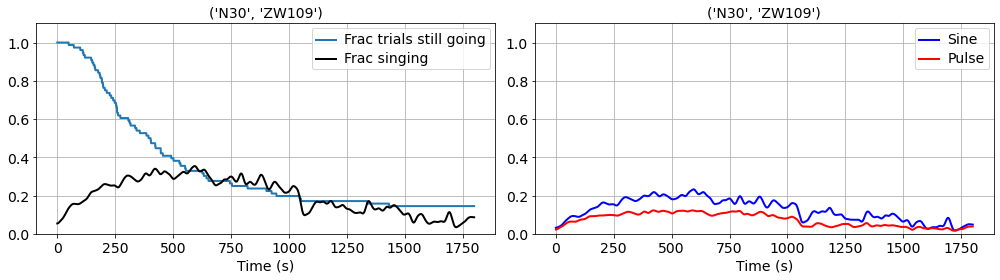

In [6]:
from scipy.ndimage import gaussian_filter1d as smooth

for ICOMBO, COMBO in zip(ICOMBOS, COMBOS):
    dfs_tr = [df_behav[df_behav.ID == i] for i in ICOMBO]
    tr_lens = [len(df_tr) for df_tr in dfs_tr]
    
    SMOOTH = int(round(10/DT))

    songs = np.nan * np.ones((len(dfs_tr), np.max(tr_lens)))
    for ctr, df_tr in enumerate(dfs_tr):
        song = np.zeros(len(df_tr), dtype=int)
        song[np.array(df_tr['S'], dtype=bool)] = 1
        song[np.array(df_tr['P'] | df_tr['F'], dtype=bool)] = 2
        songs[ctr, :len(df_tr)] = song

    frac_ongoing = np.mean(~np.isnan(songs), axis=0)

    fig, axs = plt.subplots(1, 2, figsize=(14, 4), tight_layout=True)
    axs[0].plot(DT*np.arange(songs.shape[1]), frac_ongoing, lw=2)

    frac_singing = smooth(np.mean(songs > 0, axis=0)/frac_ongoing, SMOOTH)

    axs[0].plot(DT*np.arange(songs.shape[1]), frac_singing, lw=2, c='k')
    axs[0].set_ylim(0, 1.1)
    axs[0].set_xlabel('Time (s)')
    # axs[0].set_ylabel('Fraction trials still going')
    axs[0].legend(['Frac trials still going', 'Frac singing'])

    frac_sine = smooth(np.mean(songs == 1, axis=0)/frac_ongoing, SMOOTH)
    frac_pulse = smooth(np.mean(songs == 2, axis=0)/frac_ongoing, SMOOTH)

    axs[1].plot(DT*np.arange(songs.shape[1]), frac_sine, lw=2, c='b')
    axs[1].plot(DT*np.arange(songs.shape[1]), frac_pulse, lw=2, c='r')
    axs[1].set_ylim(0, 1.1)

    axs[1].set_xlabel('Time (s)')
    axs[1].legend(['Sine', 'Pulse'])

    for ax in axs:
        ax.grid()
        set_plot(ax, title=f'{COMBO}', font_size=14)

# Avg female movement speed over time

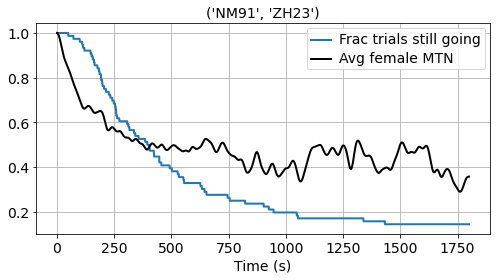

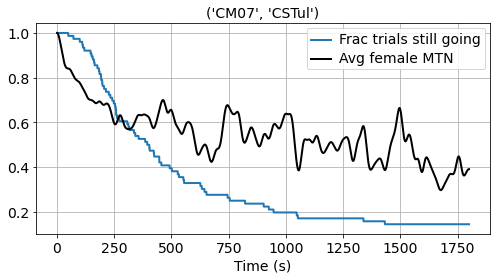

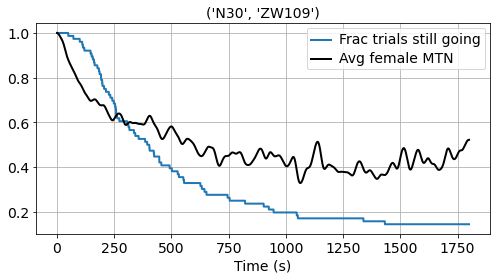

In [7]:
from scipy.ndimage import gaussian_filter1d as smooth

for ICOMBO, COMBO in zip(ICOMBOS, COMBOS):
    dfs_tr = [df_behav[df_behav.ID == i] for i in ICOMBO]
    tr_lens = [len(df_tr) for df_tr in dfs_tr]
    SMOOTH = int(round(10/DT))

    mtns = np.nan * np.ones((len(dfs_tr), np.max(tr_lens)))
    for ctr, df_tr in enumerate(dfs_tr):
        mtn = np.array(np.sqrt(df_tr['FFV']**2 + df_tr['FLS']**2))
        mtns[ctr, :len(df_tr)] = mtn 

    # normalize motion
    # for ctr in range(len(mtns)):
    #     mtns[ctr, :] = mtns[ctr, :] / np.nanmean(mtns[ctr, :])

    frac_ongoing = np.mean(~np.isnan(songs), axis=0)

    mtn_mean = smooth(np.nanmean(mtns, axis=0), SMOOTH)
    mtn_mean /= mtn_mean.max()

    fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
    ax.plot(DT*np.arange(songs.shape[1]), frac_ongoing, lw=2)
    ax.plot(DT*np.arange(songs.shape[1]), mtn_mean, lw=2, c='k')
    ax.set_xlabel('Time (s)')
    ax.legend(['Frac trials still going', 'Avg female MTN'])

    ax.grid()
    set_plot(ax, title=f'{COMBO}', font_size=14)